Zaimplementuj aplikację szacującą czas ukończenia półmaratonu dla zadanych danych

1. Umieść dane w Digital Ocean Spaces

1. Napisz notebook, który będzie Twoim pipelinem do trenowania modelu
    * czyta dane z Digital Ocean Spaces
    * czyści je
    * trenuje model (dobierz odpowiednie metryki [feature selection])
    * nowa wersja modelu jest zapisywana lokalnie i do Digital Ocean Spaces

1. Aplikacja
    * opakuj model w aplikację streamlit
    * wdróż (deploy) aplikację za pomocą Digital Ocean AppPlatform 
    * wejściem jest pole tekstowe, w którym użytkownik się przedstawia, mówi o tym
    jaka jest jego płeć, wiek i czas na 5km
    * jeśli użytkownik podał za mało danych, wyświetl informację o tym jakich danych brakuje
    * za pomocą LLM (OpenAI) wyłuskaj potrzebne dane, potrzebne dla Twojego modelu
    do określenia, do słownika (dictionary lub JSON)
    * tę część podepnij do Langfuse, aby zbierać metryki o skuteczności działania LLM'a



In [1]:
import pandas as pd
import boto3
import os
from io import StringIO
from dotenv import load_dotenv
from pycaret.regression import setup
from sklearn.model_selection import train_test_split

In [2]:

BUCKET_NAME = "gonia5555"

# Wczytanie zmiennych środowiskowych
load_dotenv()

# Inicjalizacja klienta S3
s3 = boto3.client("s3")

def load_data_from_s3(file_key):
    """Wczytuje dane z S3 do DataFrame."""
    obj = s3.get_object(Bucket=BUCKET_NAME, Key=file_key)
    csv_data = obj['Body'].read().decode('utf-8')
    df = pd.read_csv(StringIO(csv_data), sep=";")
    return df

# Wczytywanie danych dla 2023 i 2024
wroclaw_2023_df = load_data_from_s3("halfmarathon_data/halfmarathon_wroclaw_2023__final.csv")
wroclaw_2024_df = load_data_from_s3("halfmarathon_data/halfmarathon_wroclaw_2024__final.csv")

In [24]:
#sprawdzam czy DataFrame maja takie same kolumny
wroclaw_2023_df.head()

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,2.926667,00:44:47,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,01:04:59,3.080509
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,2.983333,00:45:26,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,01:06:23,3.146875
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,3.123333,00:47:34,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,01:08:24,3.242475
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,3.196667,00:48:49,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,01:10:16,3.330963
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,3.276667,00:49:31,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,01:10:27,3.339654


In [25]:
wroclaw_2024_df.head()

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,1.0,596,NIKODEM,DWORCZAK,KOŚCIAN,POL,NaN,M,1.0,M20,...,2.920000,00:45:07,2.0,3.083333,01:00:33,1.0,3.086667,0.007267,01:04:03,3.036265
1,2.0,616,MATEUSZ,KACZOR,RADOM,POL,RLTL OPTIMA RADOM,M,2.0,M20,...,2.920000,00:45:07,3.0,3.083333,01:00:38,2.0,3.103333,0.008267,01:04:24,3.052856
2,3.0,154,PATRYK,KOZŁOWSKI,RADOM,POL,RLTL-ZTE-RADOM,M,3.0,M20,...,2.920000,00:45:07,1.0,3.083333,01:00:59,3.0,3.173333,0.012467,01:04:40,3.065497
3,4.0,591,DARIUSZ,BORATYŃSKI,WROCŁAW,POL,WOSIEK TEAM AZS AWF WROCŁAW,M,4.0,M20,...,3.110000,00:47:48,4.0,3.293333,01:05:40,4.0,3.573333,0.028667,01:09:44,3.305681
4,5.0,521,SZYMON,DOROŻYŃSKI,LUBON,POL,SZYMI TEAM AZS POLITECHNIKA OPOLSKA,M,5.0,M30,...,3.153333,00:48:09,5.0,3.453333,01:06:05,5.0,3.586667,0.039800,01:10:05,3.322272


In [31]:
#Łączenie zbiorów
df = pd.concat([wroclaw_2024_df, wroclaw_2023_df], ignore_index= True)
print(df.shape)

(21957, 27)


In [32]:
#zostawiam tylko potrzebne kolumny
# Wyciągamy dane wyselekcjonowane do treningu modelu
df= df[["Płeć", "Kategoria wiekowa", "5 km Czas", "Czas"]].copy()
df.columns = ["plec", "kategoria wiekowa", "5 km czas", "czas"]

df.head()

,plec,kategoria wiekowa,5 km czas,czas
0,M,M20,00:15:06,01:04:03
1,M,M20,00:15:06,01:04:24
2,M,M20,00:15:06,01:04:40
3,M,M20,00:15:47,01:09:44
4,M,M30,00:15:07,01:10:05


In [33]:
# Snippet pomocniczy - zmiana czasu na sekundy

def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']:
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])


In [34]:
df['czas'] = df['czas'].apply(convert_time_to_seconds)
df['5 km czas'] = df['5 km czas'].apply(convert_time_to_seconds)

df.head()

,plec,kategoria wiekowa,5 km czas,czas
0,M,M20,906.0,3843.0
1,M,M20,906.0,3864.0
2,M,M20,906.0,3880.0
3,M,M20,947.0,4184.0
4,M,M30,907.0,4205.0


In [36]:
# 1. wyciągamy liczbę z tekstu (K30 -> 30, M40 -> 40)
df['wiek'] = (
    df['kategoria wiekowa']
    .astype(str)
    .str.extract('(\d+)')
)

# 2. zamieniamy na liczbę
df['wiek'] = pd.to_numeric(df['wiek'], errors='coerce')

# 3. mapowanie kategorii na średnią wieku
age_map = {
    20: 25,
    30: 35,
    40: 45,
    50: 55,
    60: 65,
    70: 75,
    80: 85
}

df['wiek'] = df['wiek'].map(age_map)

# 4. usuwamy starą kolumnę
df = df.drop(columns=['kategoria wiekowa'])

df.head()


,plec,5 km czas,czas,wiek
0,M,906.0,3843.0,25.0
1,M,906.0,3864.0,25.0
2,M,906.0,3880.0,25.0
3,M,947.0,4184.0,25.0
4,M,907.0,4205.0,35.0


In [37]:
#Usuwanie brakujących danych
df= df.dropna()
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18393 entries, 0 to 21156
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   plec       18393 non-null  object 
 1   5 km czas  18393 non-null  float64
 2   czas       18393 non-null  float64
 3   wiek       18393 non-null  float64
dtypes: float64(3), object(1)
memory usage: 718.5+ KB


In [38]:
#sprawszam duplikaty
df.duplicated().sum()

37

In [39]:
df.isna().sum().reset_index(name='ilość')

,index,ilość
0,plec,0
1,5 km czas,0
2,czas,0
3,wiek,0


In [40]:
#usuwamy outlinery
import numpy as np

def remove_outliers_iqr(df, factor=1.5):
    df_clean = df.copy()
    
    numeric_cols = df_clean.select_dtypes(include=np.number).columns
    
    for col in numeric_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        
        df_clean = df_clean[
            (df_clean[col] >= lower) & (df_clean[col] <= upper)
        ]
    
    return df_clean

df_clean = remove_outliers_iqr(df)



In [41]:
print("Przed:", df.shape)
print("Po:", df_clean.shape)


Przed: (18393, 4)
Po: (17433, 4)


In [42]:
#podział danych na zbiór treningowy i testowy
train_df = df_clean.sample(frac=0.9, random_state=42)
holdout_df =df_clean.drop(train_df.index)

In [47]:
exp = setup(
    data=df_clean,
    target='czas',
    categorical_features=['plec'],
    normalize=True,
    remove_outliers=False,
    session_id=123,
    verbose=False,
)


In [49]:
best_model = exp.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,293.6396,160716.0595,400.7145,0.8762,0.0515,0.0388,0.3570
lasso,Lasso Regression,293.6323,160704.9958,400.6998,0.8762,0.0515,0.0388,0.1770
ridge,Ridge Regression,293.6415,160716.0589,400.7145,0.8762,0.0515,0.0388,0.0120
lar,Least Angle Regression,293.6396,160716.0595,400.7145,0.8762,0.0515,0.0388,0.0130
llar,Lasso Least Angle Regression,293.6324,160704.9725,400.6997,0.8762,0.0515,0.0388,0.0120
br,Bayesian Ridge,293.6404,160716.0559,400.7145,0.8762,0.0515,0.0388,0.0120
gbr,Gradient Boosting Regressor,293.6241,160683.7268,400.6878,0.8762,0.0515,0.0388,0.0610
omp,Orthogonal Matching Pursuit,293.6927,160816.2365,400.8356,0.8761,0.0515,0.0388,0.0130
huber,Huber Regressor,288.8382,163397.8512,404.0395,0.8741,0.0518,0.0378,0.0150
lightgbm,Light Gradient Boosting Machine,296.3077,163900.7928,404.6960,0.8737,0.0520,0.0391,0.1140


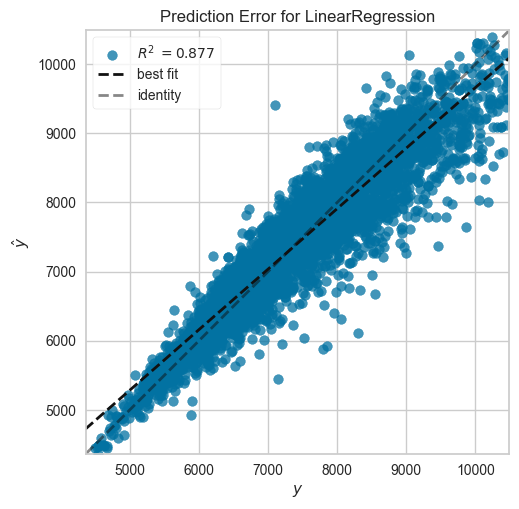

In [50]:
exp.plot_model(best_model, plot='error')

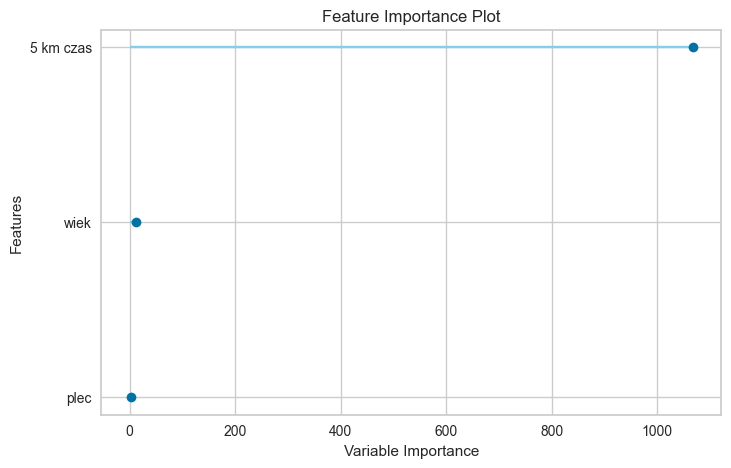

In [51]:
exp.plot_model(best_model, plot='feature')

In [52]:
tuned_model =exp. tune_model(
    best_model,
    optimize='RMSE',
    choose_better=True
)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,286.3607,154736.7450,393.3659,0.8765,0.0510,0.0382
1,289.8919,152166.4096,390.0851,0.8851,0.0497,0.0381
2,296.5936,176166.2713,419.7217,0.8602,0.0545,0.0392
3,286.8934,149190.4533,386.2518,0.8801,0.0500,0.0380
4,300.8085,178217.2860,422.1579,0.8690,0.0535,0.0393
5,295.2944,160131.2859,400.1641,0.8743,0.0510,0.0388
6,290.0941,154187.9417,392.6677,0.8787,0.0501,0.0381
7,295.5605,158759.9672,398.4469,0.8791,0.0515,0.0393
8,301.7918,169174.2808,411.3080,0.8740,0.0528,0.0397


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [55]:
exp.predict_model(best_model)
best_final_model = exp.finalize_model(best_model)
exp.save_model(best_final_model, 'half_marathon_model')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,292.1818,156729.5608,395.8908,0.8773,0.0509,0.0385


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['5 km czas', 'wiek'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['plec'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['plec'],
                                     transformer=OrdinalEncoder(cols=['plec'],
                                                                handle_missing='return_nan',
                                                                mapping=[{'col': 'plec',
                                                                          'data_type': dtype('O'),
                                                                          'mapping': K      0
 M      1
 NaN   -1
 dtype: int64}]))),
          

In [56]:
exp.predict_model(best_model, data=holdout_df)
predict_holdout_df = exp.pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,293.9291,156044.4657,395.0246,0.8784,0.0513,0.0391
